# Local minima 제거 관련 논문

1. [Adding One Neuron Can Eliminate All Bad Local Minima](https://arxiv.org/abs/1805.08671) (2018, UIUC & USC)
2. [Elimination of All Bad Local Minima in Deep Learning](https://arxiv.org/abs/1901.00279) (2019, MIT)
3. [Eliminating all bad Local Minima from Loss Landscapes without even adding an Extra Unit](https://arxiv.org/abs/1901.03909) (2019, MIT)

## Local Minima?

[Global minima로만 갈 수 있다면!](https://towardsdatascience.com/the-keys-of-deep-learning-in-100-lines-of-code-907398c76504)

#### [1] Adding One Neuron Can Eliminate All Bad Local Minima

- NeurIPS 2018
- 아이디어 제시
- Binary classification 문제로 한정, 학습 시 사용하는 loss func도 hinge loss로 한정

#### [2] Elimination of All Bad Local Minima in Deep Learning

- Any neural network에 사용할 수 있도록 확장
- 다양한 관점에서의 discussion

#### [3] Eliminating all bad Local Minima from Loss Landscapes without even adding an Extra Unit

- 위 논문들은 기존 neural net을 수정해야 함
- neural net 수정 없이 loss func만 바꾸면 가능하다는 제안
- "Is this significant?"

### 수정된 loss func

$\tilde{L}(\theta, a, b) = L(\theta)(1 + (a \exp(b) - 1)^{2}) + \lambda a^{2}$

- 기존 loss func 그대로 사용 (+ 기존 neural net 그대로 사용)
- a와 b은 학습되는 값
- $\lambda$는 hyper parameter

## method

- quote from [3]

> 학습이 진행되면 $a$는 0으로 수렴하게 될 것(regularizer term 때문에)이고 $b$는 무한대를 향해 갈 것 ($a \exp(b)$가 1이 되도록 하기 위해서)

> $L(\theta)$의 모든 local minima는 $b \rightarrow \infty$ of $\tilde{L}(\theta,a,b)$의 minima가 된다

> (잘 이해안되지만) Recall that _minima at infinity_ **do not qualify** as local minima in $\mathbb{R}^{n}$

> Any local minimum of $\tilde{L}(\theta, a, b)$ is a global minimum of $L(\theta)$

> $\tilde{L}(\theta,a,b)$ has no bad local minima


## 세 논문 모두 구현 없음...

- Fashion MNIST로 실험해보자
- [1], [2]는 뉴럴넷을 수정해야 하니 귀찮고 [3]만 구현해서 테스트

In [1]:
%reload_ext watermark

In [2]:
%watermark -v -p torch

CPython 3.7.1
IPython 7.2.0

torch 1.0.0


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(4*4*50, 500),
            nn.ReLU(),
            nn.Linear(500, 10)
        ) 

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 4*4*50)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [4]:
torch.cuda.is_available()

True

In [5]:
GPU = torch.device("cuda")

In [6]:
BATCH_SIZE = 1024

In [7]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('fmnist', train=False, transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

In [101]:
import itertools as it
import torch.nn.functional as F

def experiment(epochs: int, modified_loss: bool=False, loss_lambda: float=1.0):
    model = Net().to(GPU)
    
    a = torch.tensor(1, dtype=torch.float, device=GPU, requires_grad=True)
    b = torch.tensor(1, dtype=torch.float, device=GPU, requires_grad=True)

    def tilde_loss(loss):
        mul_term = 1 + ((a*torch.exp(b) - 1)**2)
        add_term = loss_lambda * (a**2)
        return loss * mul_term + add_term

    optimizer = optim.Adam(it.chain(model.parameters(), [a, b]), lr=1e-3, weight_decay=1e-6)

    def train(modified_loss: bool):
        model.train()
        epoch_loss = 0
        for data, target in train_loader:
            data, target = data.to(GPU), target.to(GPU)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            if modified_loss:
                loss = tilde_loss(loss)
            epoch_loss += loss.item()
            loss.backward()
            optimizer.step()
        return epoch_loss

    def test():
        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(GPU), target.to(GPU)
                output = model(data)
                test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        return test_loss, 100. * correct / len(test_loader.dataset)

    train_losses = []
    accs = []
    for epoch in range(epochs):
        train_loss = train(modified_loss)
        test_loss, acc = test()
        accs.append(acc)
        train_losses.append(train_loss)
        print(f'[epoch #{epoch+1}] train: {train_loss:.6f}, test: {test_loss:.6f} ({acc:.2f}%), a: {a.item()}, b: {b.item()}')
    return train_losses, accs

In [102]:
EPOCHS = 50

In [103]:
tl_plain, acc_plain = experiment(epochs=EPOCHS, modified_loss=False)

[epoch #1] train: 57.811754, test: 0.654236 (75.58%), a: 1.0, b: 1.0
[epoch #2] train: 32.579865, test: 0.542980 (79.40%), a: 1.0, b: 1.0
[epoch #3] train: 27.794787, test: 0.466409 (83.51%), a: 1.0, b: 1.0
[epoch #4] train: 24.690116, test: 0.421784 (85.21%), a: 1.0, b: 1.0
[epoch #5] train: 22.561862, test: 0.427491 (83.91%), a: 1.0, b: 1.0
[epoch #6] train: 21.290491, test: 0.372120 (86.57%), a: 1.0, b: 1.0
[epoch #7] train: 19.890692, test: 0.352480 (87.31%), a: 1.0, b: 1.0
[epoch #8] train: 19.207039, test: 0.359609 (86.64%), a: 1.0, b: 1.0
[epoch #9] train: 18.277970, test: 0.326712 (88.16%), a: 1.0, b: 1.0
[epoch #10] train: 17.548064, test: 0.319676 (88.70%), a: 1.0, b: 1.0
[epoch #11] train: 16.876980, test: 0.311586 (88.70%), a: 1.0, b: 1.0
[epoch #12] train: 16.239461, test: 0.309641 (88.78%), a: 1.0, b: 1.0
[epoch #13] train: 15.817682, test: 0.300544 (89.19%), a: 1.0, b: 1.0
[epoch #14] train: 15.281118, test: 0.299580 (89.36%), a: 1.0, b: 1.0
[epoch #15] train: 14.995695,

In [104]:
tl_1, acc_1 = experiment(epochs=EPOCHS, modified_loss=True, loss_lambda=1)

[epoch #1] train: 259.606741, test: 0.632149 (75.87%), a: 0.9549036026000977, b: 0.9581548571586609
[epoch #2] train: 150.974133, test: 0.546829 (78.65%), a: 0.917409360408783, b: 0.9277921319007874
[epoch #3] train: 120.572474, test: 0.478624 (82.95%), a: 0.881764829158783, b: 0.9014809727668762
[epoch #4] train: 101.113895, test: 0.443225 (84.36%), a: 0.8477728366851807, b: 0.8786135315895081
[epoch #5] train: 87.519561, test: 0.402105 (85.94%), a: 0.8151479959487915, b: 0.8585947155952454
[epoch #6] train: 76.471659, test: 0.379598 (86.87%), a: 0.7840167284011841, b: 0.841359555721283
[epoch #7] train: 68.221027, test: 0.367271 (86.91%), a: 0.7539865970611572, b: 0.8262850046157837
[epoch #8] train: 61.400712, test: 0.350836 (87.73%), a: 0.7252006530761719, b: 0.8133731484413147
[epoch #9] train: 56.212896, test: 0.346276 (87.56%), a: 0.6972360610961914, b: 0.8020187616348267
[epoch #10] train: 51.204107, test: 0.335784 (88.03%), a: 0.6703504323959351, b: 0.7923687696456909
[epoch #

In [105]:
tl_10, acc_10 = experiment(epochs=EPOCHS, modified_loss=True, loss_lambda=10)

[epoch #1] train: 767.085771, test: 0.650753 (75.94%), a: 0.9466603398323059, b: 0.958356499671936
[epoch #2] train: 596.144767, test: 0.526217 (80.65%), a: 0.8961755633354187, b: 0.9299541115760803
[epoch #3] train: 516.302641, test: 0.471916 (83.26%), a: 0.846657395362854, b: 0.9060372710227966
[epoch #4] train: 451.202633, test: 0.439298 (84.26%), a: 0.798419713973999, b: 0.8860604763031006
[epoch #5] train: 396.085032, test: 0.412930 (85.23%), a: 0.7515432834625244, b: 0.8694081902503967
[epoch #6] train: 347.874341, test: 0.384443 (86.26%), a: 0.7061277627944946, b: 0.8557937145233154
[epoch #7] train: 304.984680, test: 0.380040 (86.05%), a: 0.6622543931007385, b: 0.844967246055603
[epoch #8] train: 267.903299, test: 0.364267 (87.03%), a: 0.6198810338973999, b: 0.8363359570503235
[epoch #9] train: 234.618775, test: 0.356198 (87.25%), a: 0.579113245010376, b: 0.8298742175102234
[epoch #10] train: 205.655428, test: 0.347166 (87.76%), a: 0.5399163961410522, b: 0.8251121640205383
[epo

In [106]:
tl_100, acc_100 = experiment(epochs=EPOCHS, modified_loss=True, loss_lambda=100)

[epoch #1] train: 5776.818558, test: 0.657548 (74.88%), a: 0.9421238899230957, b: 0.9575099349021912
[epoch #2] train: 5032.325691, test: 0.561012 (78.78%), a: 0.8859692811965942, b: 0.9279482364654541
[epoch #3] train: 4424.721611, test: 0.509216 (80.98%), a: 0.8315053582191467, b: 0.9034736156463623
[epoch #4] train: 3881.240978, test: 0.457009 (83.68%), a: 0.778792679309845, b: 0.8834714889526367
[epoch #5] train: 3393.565029, test: 0.432385 (84.97%), a: 0.7278604507446289, b: 0.8672480583190918
[epoch #6] train: 2955.730202, test: 0.413240 (85.32%), a: 0.6787393689155579, b: 0.8544468879699707
[epoch #7] train: 2563.883488, test: 0.400807 (85.80%), a: 0.6314460635185242, b: 0.8444204926490784
[epoch #8] train: 2214.354816, test: 0.391820 (86.07%), a: 0.5860046744346619, b: 0.8368808627128601
[epoch #9] train: 1903.379404, test: 0.376805 (86.58%), a: 0.5424375534057617, b: 0.8315593004226685
[epoch #10] train: 1628.575182, test: 0.371053 (86.57%), a: 0.5007594227790833, b: 0.8281151

In [107]:
tl_1000, acc_1000 = experiment(epochs=EPOCHS, modified_loss=True, loss_lambda=1000)

[epoch #1] train: 55863.394470, test: 0.616460 (76.68%), a: 0.9415432810783386, b: 0.9590106010437012
[epoch #2] train: 49338.466370, test: 0.511180 (81.36%), a: 0.8847220540046692, b: 0.9309231042861938
[epoch #3] train: 43463.916931, test: 0.457315 (83.54%), a: 0.829683244228363, b: 0.9077609777450562
[epoch #4] train: 38140.232971, test: 0.412701 (85.35%), a: 0.7764532566070557, b: 0.889043390750885
[epoch #5] train: 33329.979126, test: 0.390035 (86.12%), a: 0.7250525951385498, b: 0.8739330768585205
[epoch #6] train: 28997.660248, test: 0.369772 (86.97%), a: 0.675501823425293, b: 0.8619809150695801
[epoch #7] train: 25111.173798, test: 0.354255 (87.41%), a: 0.6278221011161804, b: 0.8527243137359619
[epoch #8] train: 21639.561676, test: 0.350896 (87.62%), a: 0.5820320844650269, b: 0.845822811126709
[epoch #9] train: 18552.333618, test: 0.343353 (87.89%), a: 0.5381488800048828, b: 0.8409141302108765
[epoch #10] train: 15819.666092, test: 0.336014 (88.13%), a: 0.4961879849433899, b: 0.

## a와 b의 변화

a는 확실히 0에 수렴하고 있지만 b가 무한대로 가지 않는다.

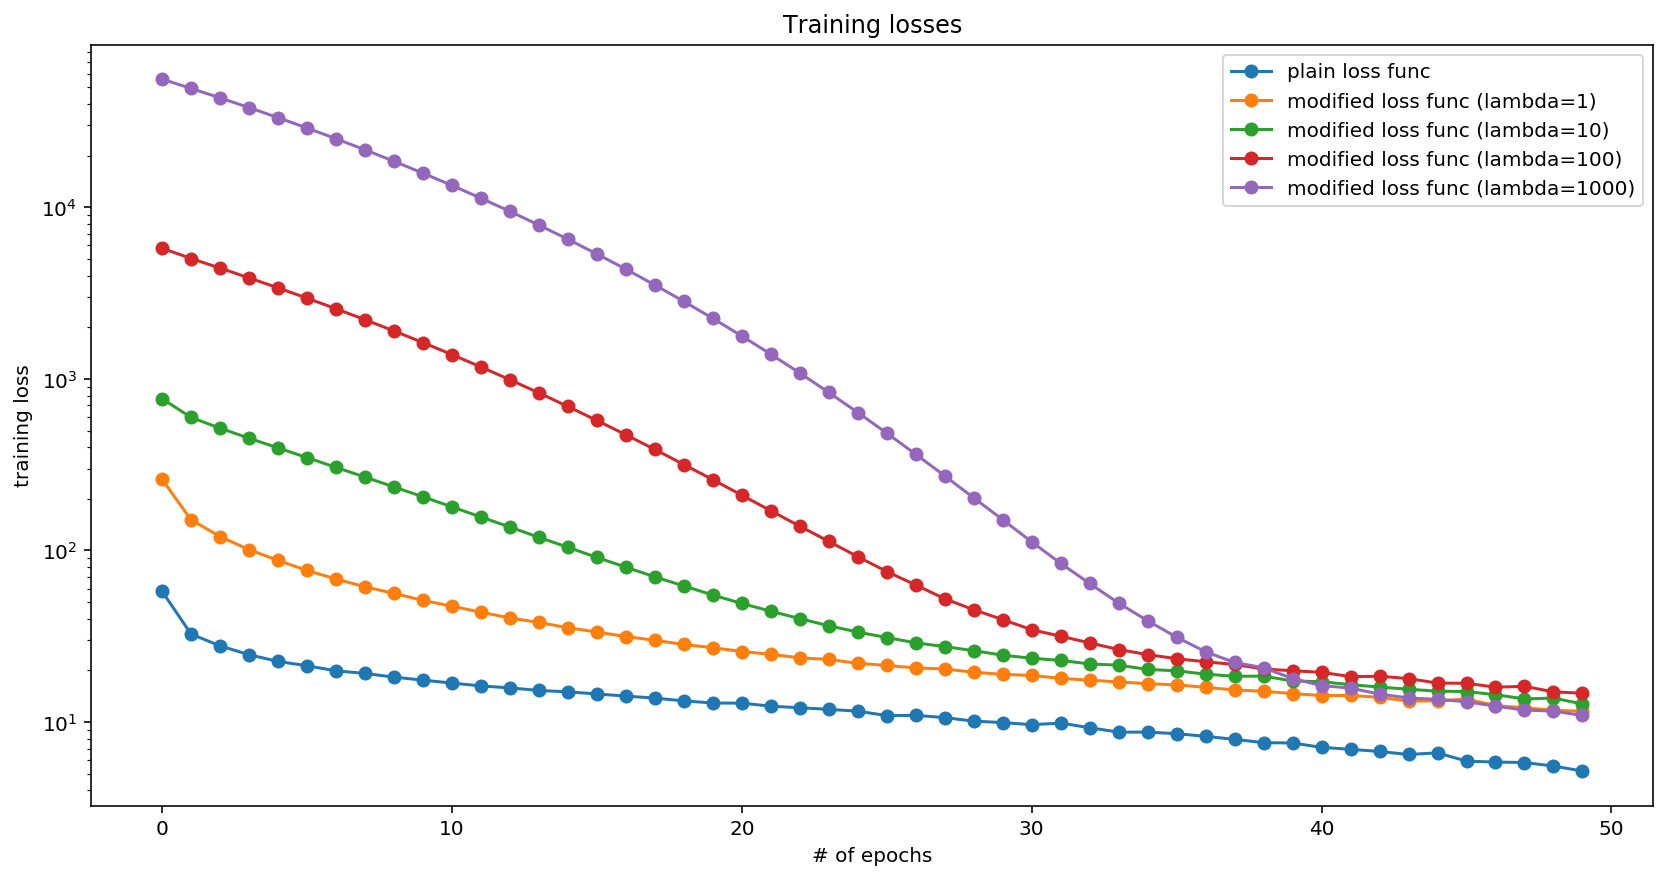

In [108]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.figure(figsize=(14, 7))
plt.title('Training losses')
plt.xlabel('# of epochs')
plt.ylabel('training loss')
plt.yscale('log')
plt.plot(tl_plain, '-o', label='plain loss func')
plt.plot(tl_1, '-o', label='modified loss func (lambda=1)')
plt.plot(tl_10, '-o', label='modified loss func (lambda=10)')
plt.plot(tl_100, '-o', label='modified loss func (lambda=100)')
plt.plot(tl_1000, '-o', label='modified loss func (lambda=1000)')
plt.legend()
plt.show()

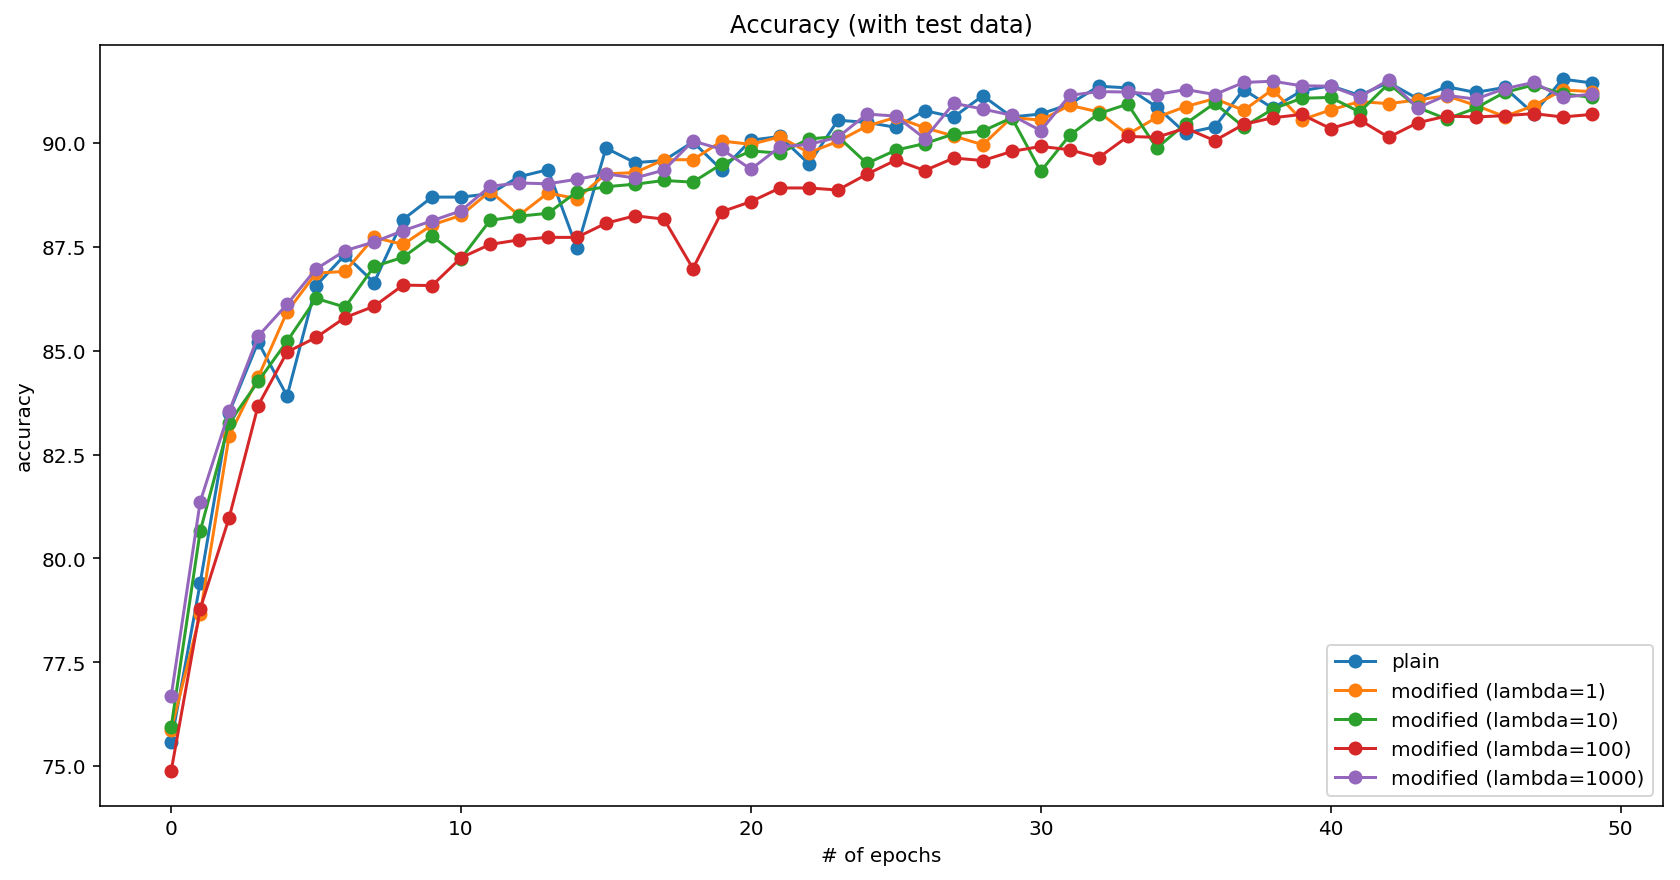

In [109]:
plt.figure(figsize=(14, 7))
plt.title('Accuracy (with test data)')
plt.xlabel('# of epochs')
plt.ylabel('accuracy')
plt.plot(acc_plain, '-o', label='plain')
plt.plot(acc_1, '-o', label='modified (lambda=1)')
plt.plot(acc_10, '-o', label='modified (lambda=10)')
plt.plot(acc_100, '-o', label='modified (lambda=100)')
plt.plot(acc_1000, '-o', label='modified (lambda=1000)')
plt.legend()
plt.show()

# 음

- Local minima에 빠졌는지 아닌지를 알 수 없기 때문에 이 실험으로는 효과를 알 수는 없다
- FashionMNIST는 복잡한 문제가 아니다
- 현재의 CNN 모델이 작다
- Local minima가 없을 수도?